In [24]:
import numpy as np
import pandas as pd

churn_data = pd.read_csv('../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')

#TotalCharges column has missing values - handle it
#Just removing those rows since they're only 11 in number and look like erroneous data
len(churn_data[churn_data['TotalCharges'].str.strip()==""])

churn_data = churn_data[churn_data['TotalCharges'].str.strip()!=""]

In [25]:
encode_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService',
                  'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
                  'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

features = list(churn_data.columns)
features.remove('Churn')
features.remove('customerID')

X = churn_data[features]
X_encoded = pd.get_dummies(X, columns=encode_columns, drop_first=True)

#Cast TotalCharges column from type object to float
X_encoded['TotalCharges'] = X_encoded['TotalCharges'].astype(float)

In [26]:
#1. Build a logistic regression model
import statsmodels.api as sm

X_encoded = sm.add_constant(X_encoded)

y = churn_data.Churn
y_encoded = y.map(lambda x:1 if x=='Yes' else 0)
#It's an imbalanced dataset: 0: 5163, 1: 1869
y_encoded.value_counts()

0    5163
1    1869
Name: Churn, dtype: int64

In [27]:
#1. Logistic regression
from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=0)

#logit = sm.Logit(y_train, X_train).fit()

#Above throws singular matrix errors. Let's check the features for collinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

def get_vif(X):
    X_matrix = X.values
    vif = [variance_inflation_factor(X_matrix, i) for i in range( X_matrix.shape[1] )]
    vif_factors = pd.DataFrame()
    vif_factors['col'] = X.columns
    vif_factors['vif'] = vif
    return vif_factors

vif_factors = get_vif(X_encoded)

#There are several features with VIF of infinity, which means they're exactly a linear combination of other features
#Let's remove these Inf VIF features
vif_factors_finite = vif_factors[vif_factors['vif']!=np.Inf]

#Now lets check VIF of columns with large VIF
large_vif_cols = vif_factors_finite[vif_factors_finite.vif > 4].col

/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/conda/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Optimization terminated successfully.
         Current function value: 0.439878
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.440064
         Iterations 7
[[955  83]
 [198 171]]
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1038
           1       0.67      0.46      0.55       369

    accuracy                           0.80      1407
   macro avg       0.75      0.69      0.71      1407
weighted avg       0.79      0.80      0.79      1407

[[900 138]
 [197 172]]
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      1038
           1       0.55      0.47      0.51       369

    accuracy                           0.76      1407
   macro avg       0.69      0.67      0.67      1407
weighted avg       0.75      0.76      0.75      1407

[[936 102]
 [223 146]]
              precision    recall  f1-score   support

           0      

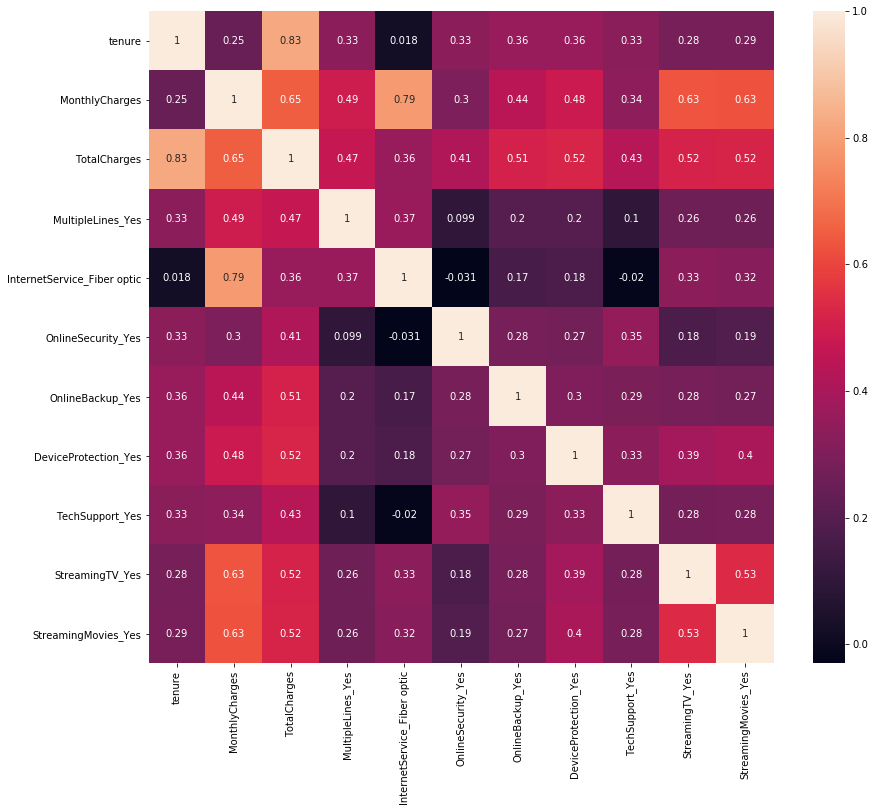

In [28]:
#Check correlation of these features
import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(figsize=(14,12))
sn.heatmap(X_encoded[large_vif_cols].corr(), annot=True)

#Tenure/TotalCharges are highly correlated (0.83)
#MonthlyCharges/InternetService_Fiber Optic are highly correlated (0.79)
#MonthlyCharges/TotalCharges are also moderately correlated (0.65)
#TotalCharges and MonthlyCharges also have moderate to high correlation with all features
#So, we remove Tenure, TotalCharges and MonthlyCharges from the list of features

non_collinear_cols = list( set(large_vif_cols) - set(['Tenure', 'MonthlyCharges', 'TotalCharges']) )

get_vif(X_encoded[non_collinear_cols])

#Split the dataset for train/test again
X_encoded_new = sm.add_constant(X_encoded[non_collinear_cols])
X_train, X_test, y_train, y_test = train_test_split(X_encoded_new, y_encoded,
                                                    test_size=0.2, random_state=0)

logit_2 = sm.Logit(y_train, X_train).fit()

logit_2.summary2()

#p-values of OnlineBackup_Yes and DeviceProtection_Yes >> 0.05. Remove these
significant_features = list(set(X_encoded_new.columns) - set(['OnlineBackup_Yes', 'DeviceProtection_Yes']))
X_encoded_3 = X_encoded_new[significant_features]

X_train, X_test, y_train, y_test = train_test_split(X_encoded_3, y_encoded,
                                                    test_size=0.2, random_state=0)


logit_3 = sm.Logit(y_train, X_train).fit()

logit_3.summary2()

y_pred = logit_3.predict(sm.add_constant(X_test))

y_pred_df = pd.DataFrame({'actual':y_test, 'pred_prob_logit':y_pred})
y_pred_df['predicted_logit'] = y_pred_df['pred_prob_logit'].apply(lambda x: 1 if x>0.5 else 0)
#Let's check the precision and recall since its an imbalanced dataset
from sklearn import metrics

print(metrics.confusion_matrix(y_pred_df.actual, y_pred_df.predicted_logit))
print(metrics.classification_report(y_pred_df.actual, y_pred_df.predicted_logit))

#Recall for 1, i.e. positive cases is low, i.e. 0.46. Precision is ok, 0.83 (0) and 0.67 (1)

#2. Random Forest
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=20, criterion='gini', random_state=0)
rfc.fit(X_train, y_train)

y_pred_rf = rfc.predict(X_test)

y_pred_df['pred_prob_rf'] = y_pred_rf
y_pred_df['predicted_rf'] = y_pred_df['pred_prob_rf'].apply(lambda x:1 if x>0.5 else 0)

print(metrics.confusion_matrix(y_pred_df.actual, y_pred_df.predicted_rf))
print(metrics.classification_report(y_pred_df.actual, y_pred_df.predicted_rf))

#Precision for 1 actually degrades to 0.55, while recall improves marginally

#3. SVM classification
from sklearn.svm import SVC

svc = SVC(kernel='rbf', random_state=0)
svc.fit(X_train, y_train)

y_pred_svm = svc.predict(X_test)

y_pred_df['predicted_svm'] = y_pred_svm

print(metrics.confusion_matrix(y_pred_df.actual,y_pred_df.predicted_svm))
print(metrics.classification_report(y_pred_df.actual,y_pred_df.predicted_svm))
print(metrics.classification_report(y_pred_df.actual,y_pred_df.predicted_logit))
print(metrics.classification_report(y_pred_df.actual,y_pred_df.predicted_rf))

#Improvement is still negligible

#4. Naive Bayes classifier
from sklearn.naive_bayes import GaussianNB

naive = GaussianNB()
naive.fit(X_train, y_train)

y_pred_naive = naive.predict(X_test)

y_pred_df['predicted_naive'] = y_pred_naive

print(metrics.classification_report(y_pred_df.actual,y_pred_df.predicted_naive))

#Precision and Recall (and hence F1-score) improve. New F1-score is 0.86 (0) and 0.55 (1)

#5. Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()

gbc.fit(X_train, y_train)

y_pred_gbc = gbc.predict(X_test)

y_pred_df['prediction_gbc'] = y_pred_gbc

print(metrics.classification_report(y_pred_df.actual, y_pred_df.prediction_gbc))

#F1-score improves marginally from 0.86 to 0.87 for y=0

#6. AdaBoost classifier
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier()
abc.fit(X_train, y_train)

y_pred_abc = abc.predict(X_test)

y_pred_df['predicted_abc'] = y_pred_abc

print(metrics.classification_report(y_pred_df.actual, y_pred_df.predicted_abc))

#No improvements. Lastly, lets try XGBoost Classifier
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

y_pred_df['predicted_xgb'] = y_pred_xgb

print(metrics.classification_report(y_pred_df.actual,y_pred_df.predicted_xgb))

#Logistic regression looks like a good option compared  to other advanced classifiers
#Let's try getting the optimum prob. threshold for logistic regression

fpr, tpr, thresholds = metrics.roc_curve(y_pred_df.actual, y_pred_df.pred_prob_logit, 
                                        drop_intermediate=False)

tpr_fpr = pd.DataFrame({'tpr':tpr, 'fpr':fpr, 'thresholds': thresholds})

tpr_fpr['diff'] = tpr_fpr['tpr']-tpr_fpr['fpr']

tpr_fpr.sort_values('diff', ascending=False)

#Threshold of 0.29 gives the max tpr-fpr. Let's use the same
y_pred_logit_new = y_pred_df['pred_prob_logit'].apply(lambda x: 1 if x > 0.29 else 0)

y_pred_df['y_pred_logit_new'] = y_pred_logit_new

print(metrics.classification_report(y_pred_df.actual, y_pred_df.y_pred_logit_new))

#We get F1-score of 0.81 (0) and 0.60 (1). Hence, best model performance so far

#7. Logistic Regression with oversampling of the minority class
y_encoded.value_counts()
#0    5163
#1    1869

#8. Try oversampling the smaller (1) class label, then use optimal prob. threshold
#using Youden's index
from sklearn.utils import resample, shuffle

churn_data_yes = churn_data[churn_data.Churn=='Yes']
churn_data_no = churn_data[churn_data.Churn=='No']

churn_data_yes_resampled = resample(churn_data_yes, replace=True, 
                                    n_samples = len(churn_data_no))

churn_data_new = pd.concat([churn_data_yes_resampled, churn_data_no])
churn_data_new = shuffle(churn_data_new)

X = churn_data_new[features]
y = churn_data_new.Churn
y_encoded = y.map(lambda x:1 if x=='Yes' else 0)
y_encoded.value_counts()

X_encoded = pd.get_dummies(X, columns=encode_columns, drop_first=True)
X_encoded = sm.add_constant(X_encoded)

#As earlier, use only the significant features
X_encoded = X_encoded[significant_features]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=0)

logit_resampled = sm.Logit(y_train, X_train).fit()

logit_resampled.summary2()

y_pred_logit_res = logit_resampled.predict(X_test)
y_pred_logit_res_binary = y_pred_logit_res.map(lambda x: 1 if x > 0.5 else 0)

#Check the classification metrics of the logit model with oversampling
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_logit_res_binary))
#=> Accuracy of 74%

print(metrics.classification_report(y_test, y_pred_logit_res_binary))

#=> F1score of 74% and 73 % => Major improvement!!

In [29]:
#Next, let's find the optimal prob. threshold for the new logit model
fpr,tpr,thresholds = metrics.roc_curve(y_test, y_pred_logit_res, 
                                       drop_intermediate=False)

new_logit_df = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
new_logit_df['diff'] = new_logit_df.tpr-new_logit_df.fpr
new_logit_df.sort_values(by='diff', ascending=False)

#Threshold of 0.513 is optimal (gives max tpr-fpr)
y_pred_logit_res_new = y_pred_logit_res.map(lambda x: 1 if x > 0.513 else 0)

print(metrics.accuracy_score(y_test, y_pred_logit_res_new))
# => accuracy of 74.1%
print(metrics.classification_report(y_test, y_pred_logit_res_new))
#Gives F1-score of 0.74
#Marginally better F1-score, so we stick with the last model
print(metrics.accuracy_score(y_test, y_pred_logit_res_new))
#Gives accuracy of 75.5%
#Compare with earlier model with default 0.5 threshold
#print(metrics.classification_report(y_test, y_pred_logit_res_binary))

0.7541142303969022
              precision    recall  f1-score   support

           0       0.74      0.76      0.75      1000
           1       0.77      0.75      0.76      1066

    accuracy                           0.75      2066
   macro avg       0.75      0.75      0.75      2066
weighted avg       0.75      0.75      0.75      2066

0.7541142303969022
